<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/flair_ner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flairを使って固有表現抽出(Named Entity Recognition)
- https://hironsan.hatenablog.com/entry/implementing-contextual-string-embeddings-for-named-entity-recognition
- https://github.com/flairNLP/flair

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!nvidia-smi
!nvcc -V
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

Sun Feb 23 11:35:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [3]:
!pip install flair

     |████████████████████████████████| 143kB 5.0MB/s 
     |████████████████████████████████| 491kB 59.3MB/s 
     |████████████████████████████████| 798kB 53.7MB/s 
     |████████████████████████████████| 235kB 59.2MB/s 
     |████████████████████████████████| 1.0MB 55.0MB/s 
     |████████████████████████████████| 1.0MB 57.9MB/s 
     |████████████████████████████████| 870kB 36.8MB/s 
     |████████████████████████████████| 3.8MB 46.8MB/s 
  Created wheel for segtok: filename=segtok-1.5.7-cp36-none-any.whl size=23258 sha256=1cebe7a390eaab6ca3b0290ae0a10860bde8af1d70b7c5d2f43cd22a05d4c39e
  Stored in directory: /root/.cache/pip/wheels/15/ee/a8/6112173f1386d33eebedb3f73429cfa41a4c3084556bcee254
  Created wheel for mpld3: filename=mpld3-0.3-cp36-none-any.whl size=116679 sha256=351b137997324f9886240dae181996fbe558bdc1492af09d399a2640be71ed6d
  Stored in directory: /root/.cache/pip/wheels/c0/47/fb/8a64f89aecfe0059830479308ad42d62e898a3e3cefdf6ba28
  Created wheel for sqlitedict: filename

In [4]:
import os
import sys
import pprint
import random
import numpy as np
import pandas as pd
from IPython.display import Image, display_png
import matplotlib.pyplot as plt
import flair
from flair.datasets import ColumnCorpus
from flair.embeddings import StackedEmbeddings, FlairEmbeddings
from flair.data import Sentence
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer

In [7]:
# flairは自動でGPUが使えるか判断する
print(flair.device)

cuda:0


## コーパスをダウンロード
- モデルを学習するためのデータの用意
- ウィキニュース日本語版をMeCabで形態素解析してIOB2タグでタグ付けしたコーパス
 - IOB2 (Inside-outside-beggining)
- 全部で500文にタグ付け
- タグ付けの基準はIREXの定義に基づいている


In [0]:
# https://github.com/Hironsan/iob2corpus
%cd "/content/drive/My Drive/git/corpus"
!wget https://raw.githubusercontent.com/Hironsan/IOB2Corpus/master/ja.wikipedia.conll

/content/drive/My Drive/git/corpus
--2020-02-22 10:26:39--  https://raw.githubusercontent.com/Hironsan/IOB2Corpus/master/ja.wikipedia.conll
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1297592 (1.2M) [text/plain]
Saving to: ‘ja.wikipedia.conll’

ja.wikipedia.conll  100%[===================>]   1.24M  --.-KB/s    in 0.05s   

2020-02-22 10:26:39 (24.1 MB/s) - ‘ja.wikipedia.conll’ saved [1297592/1297592]



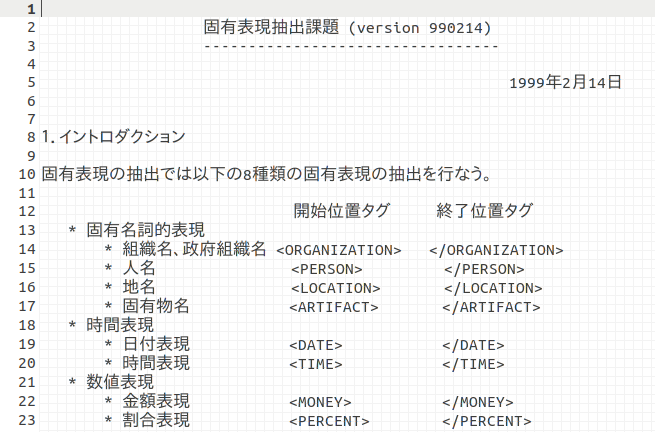

In [13]:
# IREX定義
display_png(Image("/content/drive/My Drive/git/images/flair3.png"))

In [0]:
CORPUS_PATH = "/content/drive/My Drive/git/corpus/"
MODEL_PATH = '/content/drive/My Drive/git/model/flair/example-ner/'

## ja.wikipedia.conll の中身

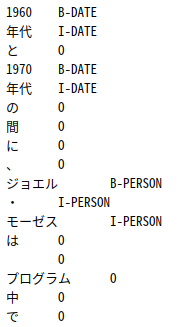

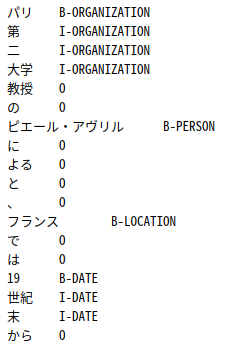

In [14]:
display_png(Image("/content/drive/My Drive/git/images/flair1.png"))
print('\n')
display_png(Image("/content/drive/My Drive/git/images/flair2.png"))

## ダウンロードしたコーパスを読み込む

In [8]:
columns = {0: 'text', 1: 'ner'}
data_folder = '.'
corpus = ColumnCorpus(CORPUS_PATH, columns, train_file='ja.wikipedia.conll')

2020-02-23 11:52:14,638 Reading data from /content/drive/My Drive/git/corpus
2020-02-23 11:52:14,640 Train: /content/drive/My Drive/git/corpus/ja.wikipedia.conll
2020-02-23 11:52:14,641 Dev: None
2020-02-23 11:52:14,642 Test: None


## タグを用意(今回は固有表現認識を行うので、tag_type='ner'を指定)

In [16]:
tag_type = 'ner'
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)
pprint.pprint(tag_dictionary.idx2item)
# コーパス中に存在するタグに加えて、<unk>、<START>、<STOP>という3つのタグが付与される

[b'<unk>',
 b'O',
 b'B-DATE',
 b'I-DATE',
 b'B-LOCATION',
 b'B-PERSON',
 b'I-PERSON',
 b'I-LOCATION',
 b'B-ARTIFACT',
 b'I-ARTIFACT',
 b'B-ORGANIZATION',
 b'I-ORGANIZATION',
 b'B-EVENT',
 b'I-EVENT',
 b'B-PERCENT',
 b'B-NUMBER',
 b'I-NUMBER',
 b'B-OTHER',
 b'I-OTHER',
 b'I-PERCENT',
 b'B-MONEY',
 b'I-MONEY',
 b'B-TIME',
 b'I-TIME',
 b'<START>',
 b'<STOP>']


## 使用する分散表現を用意
- 日本語の事前学習済み言語モデルを指定

In [17]:
embedding_types = [
    FlairEmbeddings('ja-forward'),
    FlairEmbeddings('ja-backward'),
]
embeddings = StackedEmbeddings(embeddings=embedding_types)

2020-02-23 12:12:18,178 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/lm__char-forward__ja-wikipedia-3GB/japanese-forward.pt not found in cache, downloading to /tmp/tmpgy0bx1ii


100%|██████████| 335383050/335383050 [00:18<00:00, 18106739.03B/s]

2020-02-23 12:12:37,432 copying /tmp/tmpgy0bx1ii to cache at /root/.flair/embeddings/japanese-forward.pt


2020-02-23 12:12:38,980 removing temp file /tmp/tmpgy0bx1ii
2020-02-23 12:12:51,304 https://s3.eu-central-1.amazonaws.com/alan-nlp/resources/embeddings-v0.4.1/lm__char-backward__ja-wikipedia-3GB/japanese-backward.pt not found in cache, downloading to /tmp/tmptw75riqr


100%|██████████| 335383032/335383032 [00:23<00:00, 13995365.44B/s]

2020-02-23 12:13:15,976 copying /tmp/tmptw75riqr to cache at /root/.flair/embeddings/japanese-backward.pt


2020-02-23 12:13:17,020 removing temp file /tmp/tmptw75riqr


## 学習させるモデルを定義
- ラベル間の依存関係を考慮するため、use_crf=TrueでCRFを使う

In [0]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type=tag_type,
                        use_crf=True)

## 学習

In [20]:
trainer = ModelTrainer(tagger, corpus)
trainer.train(MODEL_PATH,
                learning_rate=0.1,
                mini_batch_size=32,
                max_epochs=50)

2020-02-23 12:35:36,265 ----------------------------------------------------------------------------------------------------
2020-02-23 12:35:36,267 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.3, inplace=False)
        (encoder): Embedding(15174, 100)
        (rnn): LSTM(100, 2048, num_layers=2, dropout=0.3)
        (decoder): Linear(in_features=2048, out_features=15174, bias=True)
      )
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.3, inplace=False)
        (encoder): Embedding(15174, 100)
        (rnn): LSTM(100, 2048, num_layers=2, dropout=0.3)
        (decoder): Linear(in_features=2048, out_features=15174, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4096, out_features=4096, bias=True)
  (rnn): LSTM(4096, 256, batch_f

{'dev_loss_history': [tensor(12.8157, device='cuda:0'),
  tensor(12.7044, device='cuda:0'),
  tensor(13.4918, device='cuda:0'),
  tensor(13.5019, device='cuda:0'),
  tensor(12.7385, device='cuda:0'),
  tensor(12.7307, device='cuda:0'),
  tensor(12.4600, device='cuda:0'),
  tensor(12.3439, device='cuda:0'),
  tensor(12.2483, device='cuda:0'),
  tensor(12.3324, device='cuda:0'),
  tensor(12.3956, device='cuda:0'),
  tensor(12.4686, device='cuda:0'),
  tensor(12.6066, device='cuda:0'),
  tensor(12.5370, device='cuda:0'),
  tensor(12.3721, device='cuda:0'),
  tensor(12.4798, device='cuda:0'),
  tensor(12.7700, device='cuda:0'),
  tensor(12.6927, device='cuda:0'),
  tensor(12.6148, device='cuda:0'),
  tensor(12.7178, device='cuda:0'),
  tensor(12.8415, device='cuda:0'),
  tensor(12.7626, device='cuda:0'),
  tensor(12.7809, device='cuda:0'),
  tensor(12.8011, device='cuda:0'),
  tensor(12.8619, device='cuda:0'),
  tensor(12.7506, device='cuda:0'),
  tensor(12.6630, device='cuda:0'),
  tensor

## 最も良いモデルを読み込む

In [21]:
model = SequenceTagger.load(MODEL_PATH + 'final-model.pt')

2020-02-23 13:10:52,357 loading file /content/drive/My Drive/git/model/flair/example-ner/final-model.pt


## 予測

In [22]:
sentence = Sentence('私 は 田中 と 東京 駅 へ 行っ た')
model.predict(sentence)
print(sentence.to_tagged_string())

私 は 田中 <B-PERSON> と 東京 <B-LOCATION> 駅 <I-LOCATION> へ 行っ た
